In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [2]:
tower_left = cv2.imread('./resources/tower_left.jpg')
tower_right = cv2.imread('./resources/tower_right.jpg')

In [3]:
# Convert images to double
tower_left_double = cv2.convertScaleAbs(tower_left, cv2.CV_64F)
tower_right_double = cv2.convertScaleAbs(tower_right, cv2.CV_64F)

In [4]:
# Convert images to grayscale
tower_left_gray = cv2.cvtColor(tower_left_double, cv2.COLOR_BGR2GRAY)
tower_right_gray = cv2.cvtColor(tower_right_double, cv2.COLOR_BGR2GRAY)

In [5]:
# Function for displaying multiple images
# Used for displaying plots below
def plot_figures(figures, figure_width=15, figure_height=15):
    fig, axes = plt.subplots(len(figures), 1, figsize=(figure_width, figure_height))
    for axes, (title, image) in zip(axes, figures.items()):
        axes.imshow(image, cmap='gray')
        axes.set_title(title)
        axes.axis('off')
    plt.tight_layout()
    plt.show()

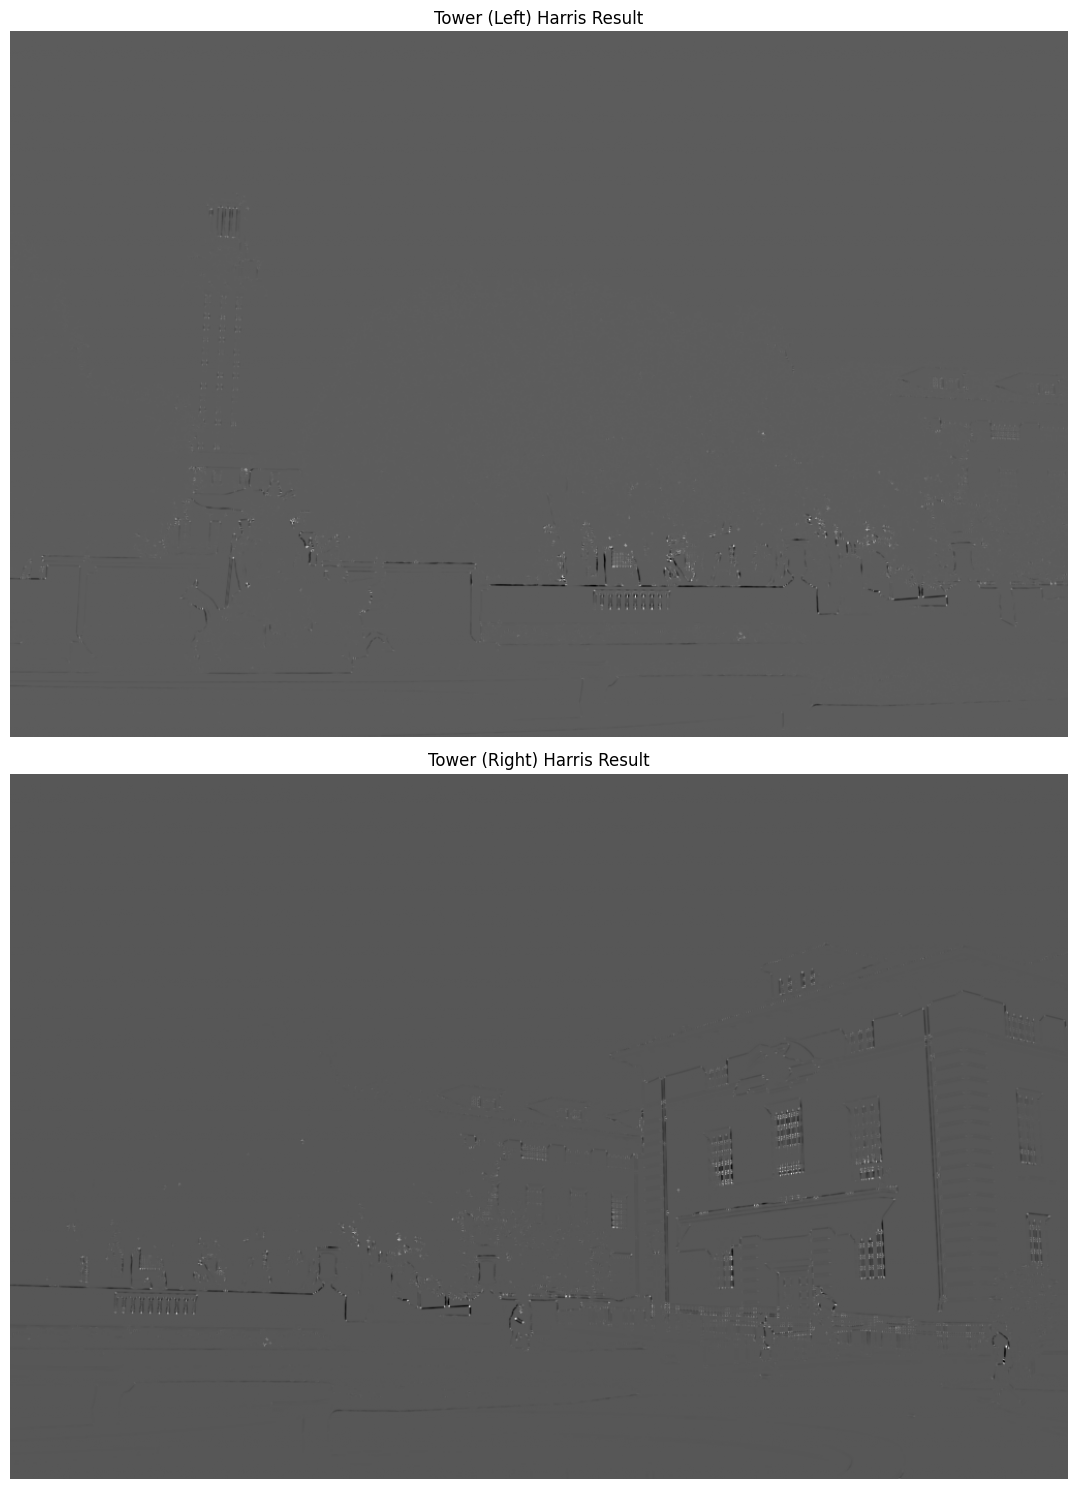

In [6]:
# Images with Harris detected features
# img - Input image. It should be grayscale and float32 type.
# blockSize - It is the size of neighbourhood considered for corner detection
# ksize - Aperture parameter of the Sobel derivative used.
# k - Harris detector free parameter in the equation.
tower_left_harris = cv2.cornerHarris(tower_left_gray, 2, 3, 0.04)
tower_right_harris = cv2.cornerHarris(tower_right_gray, 2, 3, 0.04)

# Display for Harris results
image_dictionary = {}
image_dictionary["Tower (Left) Harris Result"] = tower_left_harris
image_dictionary["Tower (Right) Harris Result"] = tower_right_harris
plot_figures(image_dictionary)

In [7]:
# Result is dilated for marking the corners
tower_left_harris_dilated = cv2.dilate(tower_left_harris, None)
tower_right_harris_dilated = cv2.dilate(tower_right_harris, None)

In [8]:
def get_keypoints(corner_image, threshold, patch_size, max_keypoints):
    keypoints = cv2.threshold(corner_image, threshold * corner_image.max(), 255, cv2.THRESH_BINARY)[1]
    keypoints = cv2.findNonZero(keypoints)
    keypoints = sorted(keypoints, key=lambda p: corner_image[p[0][1], p[0][0]], reverse=True)[:max_keypoints]
    keypoints = [cv2.KeyPoint(float(p[0][0]), float(p[0][1]), patch_size) for p in keypoints]
    return keypoints

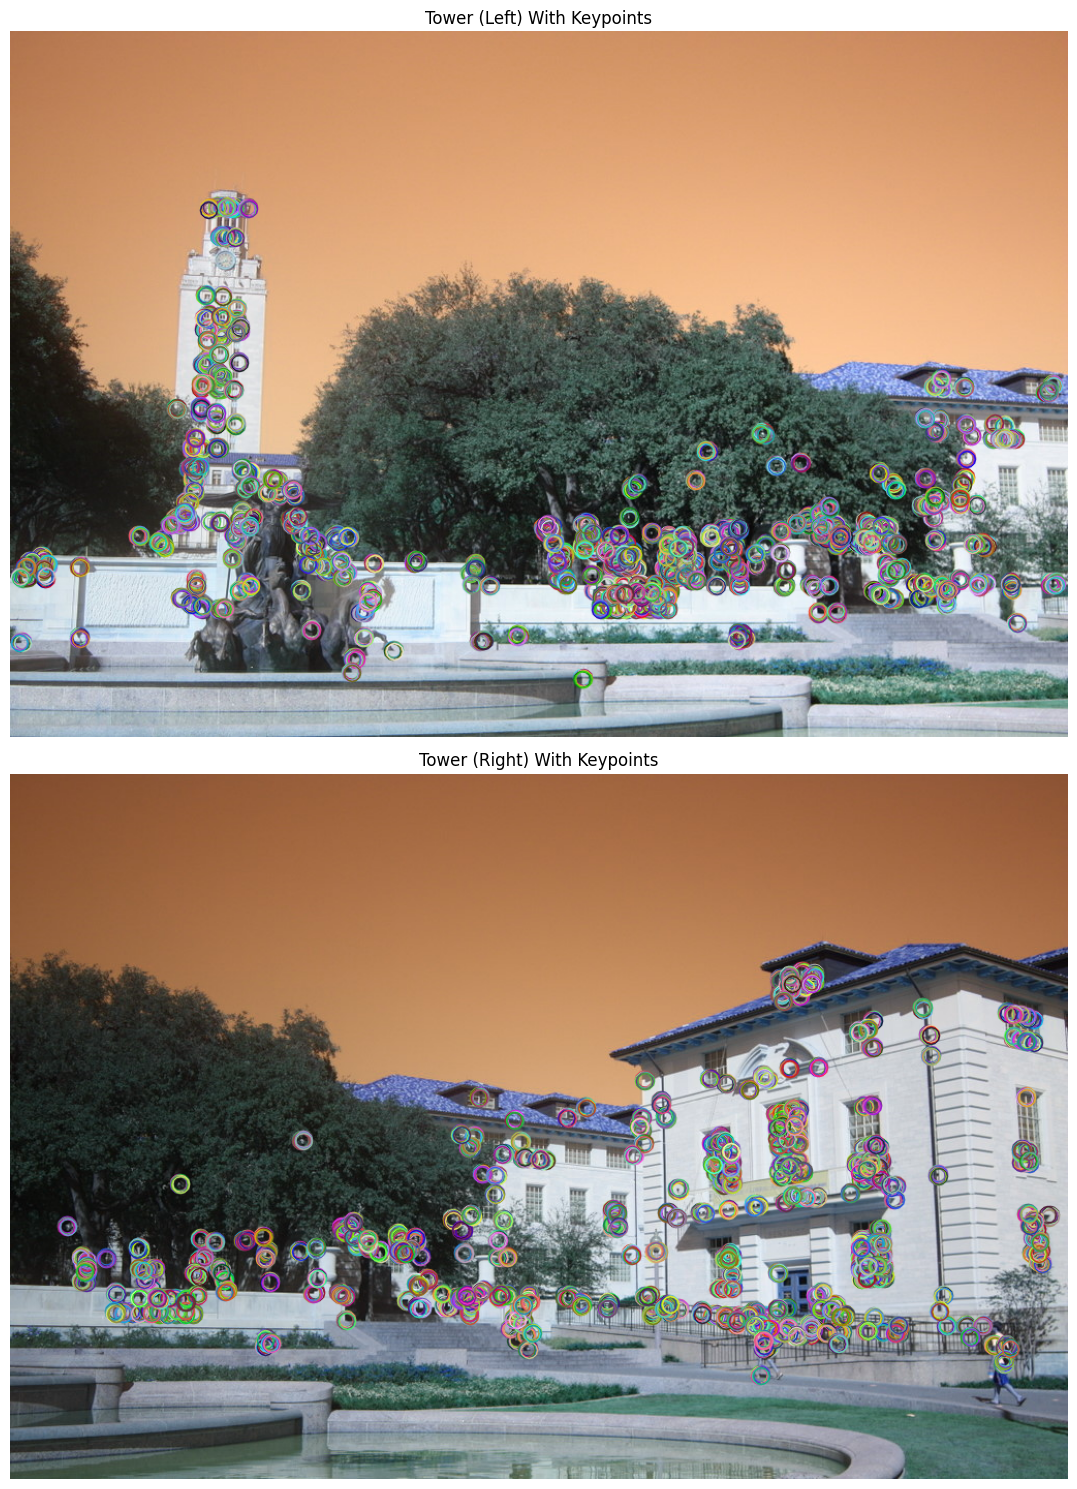

In [9]:
THRESHOLD = 0.01
PATCH_SIZE = 16
MAX_KEYPOINTS = 6000

# Good results:
# 4000, 16 -> good homography
# 1000, 16 -> good homography
# Patch size 32 -> features are too few if 1000 points only

# [1] -> for threshold converted image
# Find non zero -> detected keypoints
tower_left_keypoints = get_keypoints(tower_left_harris_dilated, THRESHOLD, PATCH_SIZE, MAX_KEYPOINTS)

# If threshold is 0.01, all are 0s
tower_right_keypoints = get_keypoints(tower_right_harris_dilated, THRESHOLD, PATCH_SIZE, MAX_KEYPOINTS)

# Display keypoints found in images
tower_left_with_keypoints = cv2.drawKeypoints(tower_left, tower_left_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
tower_right_with_keypoints = cv2.drawKeypoints(tower_right, tower_right_keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

image_dictionary = {}
image_dictionary["Tower (Left) With Keypoints"] = tower_left_with_keypoints
image_dictionary["Tower (Right) With Keypoints"] = tower_right_with_keypoints
plot_figures(image_dictionary)

In [10]:
# Function for extracting patches
# Higher patch size, fewer descriptors
# Lower patch size, smaller size of descriptor
def extract_patches(image, keypoints, patch_size=PATCH_SIZE):
    half_size = patch_size // 2
    descriptors = []

    for point in keypoints:
        x, y = map(int, point.pt)  # Extract coordinates
        if y - half_size >= 0 and y + half_size < image.shape[0] and x - half_size >= 0 and x + half_size < image.shape[1]:
            patch = image[y - half_size:y + half_size, x - half_size:x + half_size]
            descriptors.append(patch.flatten())  # Convert patch to 1D vector

    return descriptors

In [11]:
tower_left_descriptors = extract_patches(tower_left, tower_left_keypoints)
print(len(tower_left_descriptors))

tower_right_descriptors = extract_patches(tower_right, tower_right_keypoints)
print(len(tower_right_descriptors))

6000
6000


In [12]:
# Perform min-max normalization on the descriptors
def normalize_descriptors(descriptors):
    min_vals = descriptors.min(axis=1, keepdims=True)
    max_vals = descriptors.max(axis=1, keepdims=True)
    range_vals = max_vals - min_vals + 1e-10  # Avoid division by zero
    return (descriptors - min_vals) / range_vals
    # return [cv2.normalize(descriptor, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX).astype(np.float64) for descriptor in descriptors]

normalized_tower_left_descriptors = normalize_descriptors(np.array(tower_left_descriptors))
normalized_tower_right_descriptors = normalize_descriptors(np.array(tower_right_descriptors))

In [13]:
def compute_eucledian_distance(left_descriptors, right_descriptors):
    distance_list = []

    for x in left_descriptors:
        distance = [cv2.norm(x, y, cv2.NORM_L2) for y in right_descriptors]
        distance_list.append(distance)
    return distance_list
    # for faster testing:
    # return cdist(left_descriptors, right_descriptors, metric='euclidean')

distances = compute_eucledian_distance(normalized_tower_left_descriptors, normalized_tower_right_descriptors)
print(len(distances))

6000


In [14]:
def select_matches_based_on_threshold(distances, threshold=5):
    matches = []
    for i in range(len(distances)):
        for j in range(len(distances[i])):
            if(distances[i][j] < threshold):
                match = cv2.DMatch(_queryIdx=i, _trainIdx=j, _distance=distances[i][j])
                matches.append(match)
    return matches

matches = select_matches_based_on_threshold(distances)
print(len(matches))

# For getting the X strongest matches
# matches = sorted(matches, key=lambda x: x.distance)
# matches = matches[:100]
# print(len(matches))

13873


In [15]:
LEFT_KEYPOINT_MATCHES = np.float64([tower_left_keypoints[m.queryIdx].pt for m in matches])
RIGHT_KEYPOINT_MATCHES = np.float64([tower_right_keypoints[m.trainIdx].pt for m in matches])

def normalize_keypoints(keypoints):
    mean = np.mean(keypoints, axis=0)
    std = np.std(keypoints, axis=0)
    return (keypoints - mean) / std

def estimate_affine_transformation(image1_keypoints, image2_keypoints):
    keypoints1 = normalize_keypoints(image1_keypoints)
    keypoints2 = normalize_keypoints(image2_keypoints)
    
    affine_matrix, affine_inliers = cv2.estimateAffine2D(keypoints1, keypoints2, method=cv2.RANSAC, ransacReprojThreshold=1.0)
    affine_inliers = affine_inliers.ravel().astype(bool)
    return affine_matrix, affine_inliers

affine_matrix, affine_inliers = estimate_affine_transformation(LEFT_KEYPOINT_MATCHES, RIGHT_KEYPOINT_MATCHES)
print(affine_matrix)
print(sum(affine_inliers))

[[ 1.04428254 -0.08918476 -0.52997285]
 [ 0.05320636  0.96518992  0.02658312]]
11067


In [16]:
def get_affine_residual(affine_matrix, image1_keypoints, image2_keypoints, inliers):
    """Calculate squared distance residuals for affine transformation."""
    transformed_pts = cv2.transform(image1_keypoints[inliers].reshape(-1, 1, 2), affine_matrix).reshape(-1, 2)
    residuals = np.array([cv2.norm(a, b, cv2.NORM_L2) ** 2 for a, b in zip(transformed_pts, image2_keypoints[inliers])])
    return cv2.mean(residuals)

average_affine_residual = get_affine_residual(affine_matrix, LEFT_KEYPOINT_MATCHES, RIGHT_KEYPOINT_MATCHES, affine_inliers)
print(average_affine_residual[0])


194814.58987798856


In [17]:
def estimate_homography_transformation(image1_keypoints, image2_keypoints):
    homography_matrix, homography_inliers = cv2.findHomography(image2_keypoints, image1_keypoints, cv2.RANSAC, ransacReprojThreshold=1.0)
    homography_inliers = homography_inliers.ravel().astype(bool)
    return homography_matrix, homography_inliers

homography_matrix, homography_inliers = estimate_homography_transformation(LEFT_KEYPOINT_MATCHES, RIGHT_KEYPOINT_MATCHES)
print(homography_matrix)
print(sum(homography_inliers))

[[ 7.77158562e-01  2.89821099e-03  4.51569058e+02]
 [-1.23205169e-01  8.92361024e-01  7.65916410e+01]
 [-1.88839179e-04 -6.65904977e-05  1.00000000e+00]]
2198


In [18]:
def get_homography_residual(homography_matrix, image1_keypoints, image2_keypoints, inliers):
    """Calculate squared distance residuals for homography transformation."""
    transformed_pts = cv2.perspectiveTransform(image1_keypoints[inliers].reshape(-1, 1, 2), homography_matrix).reshape(-1, 2)
    residuals = np.array([cv2.norm(a, b, cv2.NORM_L2) ** 2 for a, b in zip(transformed_pts, image2_keypoints[inliers])])
    return cv2.mean(residuals)

average_homography_residual = get_homography_residual(homography_matrix, LEFT_KEYPOINT_MATCHES, RIGHT_KEYPOINT_MATCHES, homography_inliers)
print(average_homography_residual[0])

968206.264467176


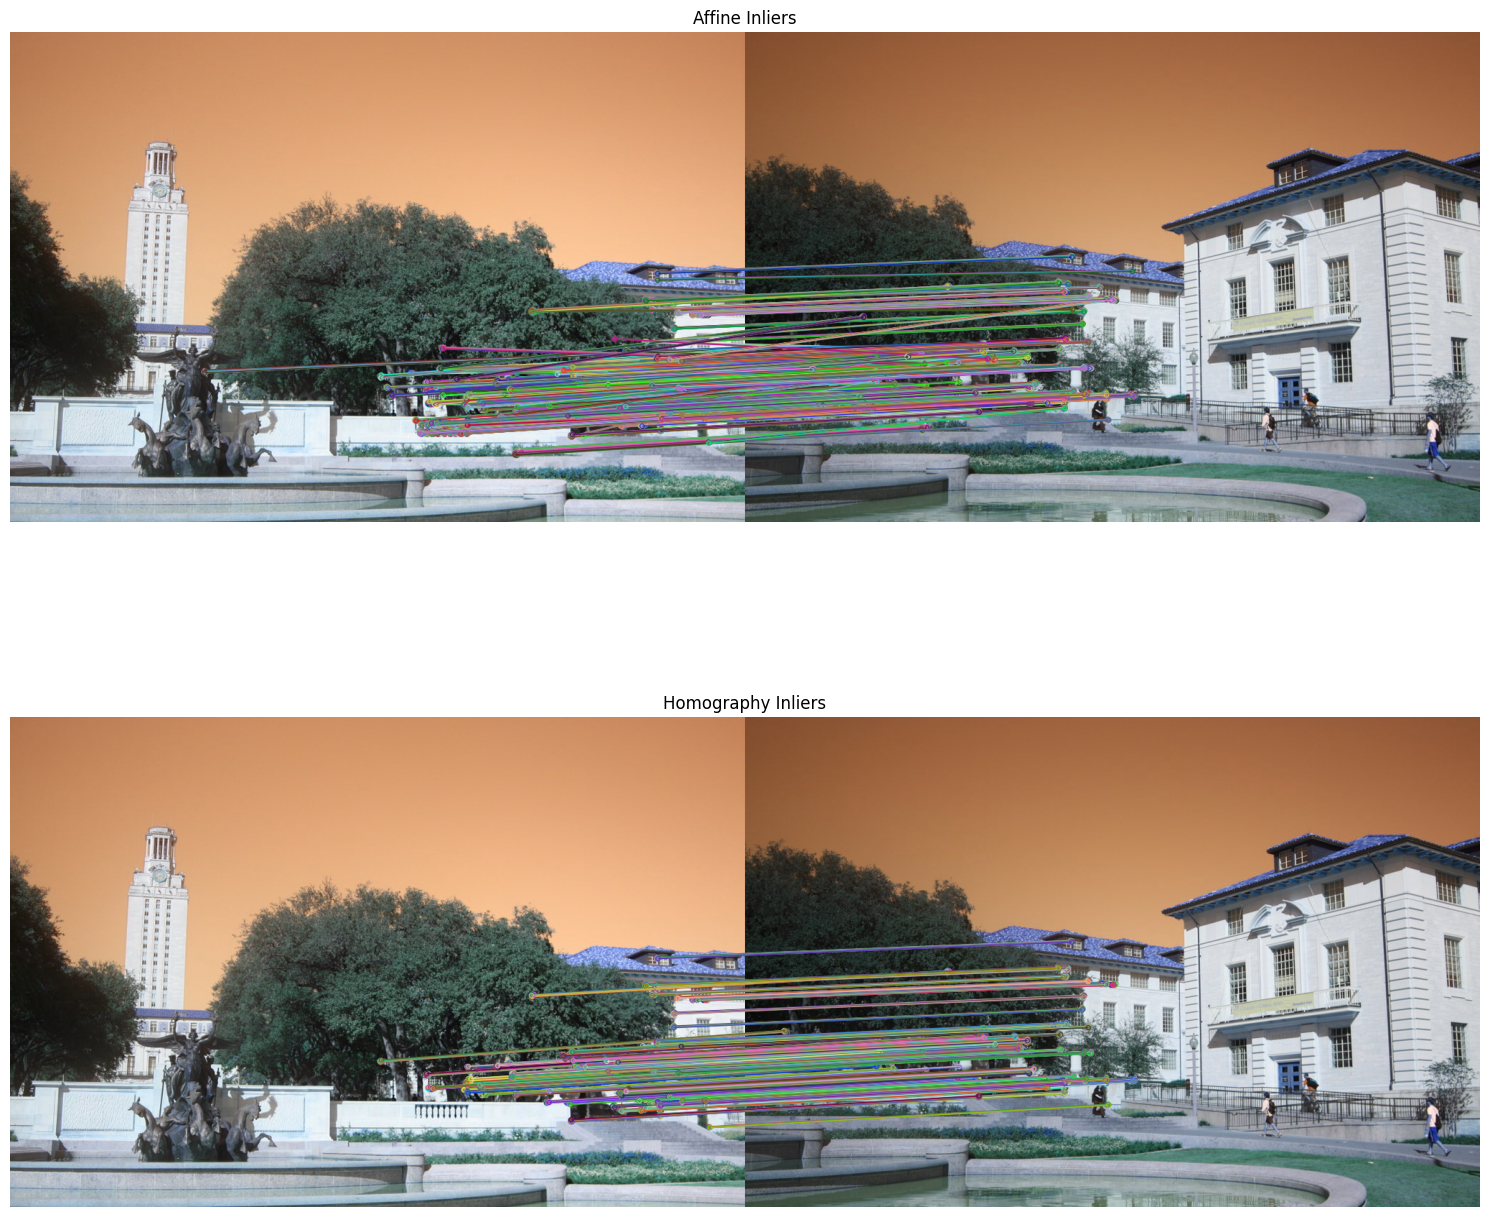

In [19]:
def draw_inliers(image1, keypoints1, image2, keypoints2, matches, inliers):
    inlier_matches = [m for i, m in enumerate(matches) if inliers[i]]
    match_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return match_img

affine_inliers_image = draw_inliers(tower_left, tower_left_keypoints, tower_right, tower_right_keypoints, matches, affine_inliers)
homography_inliers_image = draw_inliers(tower_left, tower_left_keypoints, tower_right, tower_right_keypoints, matches, homography_inliers)

image_dictionary = {}
image_dictionary["Affine Inliers"] = affine_inliers_image
image_dictionary["Homography Inliers"] = homography_inliers_image
plot_figures(image_dictionary)

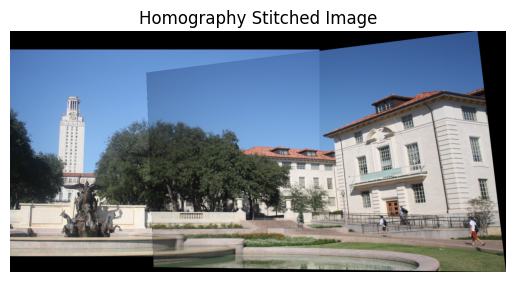

True

In [20]:
def warp_image_homography(img1, img2, homography):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Find the canvas size after transformation
    corners_img1 = np.float32([[0, 0], [w1, 0], [0, h1], [w1, h1]]).reshape(-1, 1, 2)
    corners_img2 = np.float32([[0, 0], [w2, 0], [0, h2], [w2, h2]]).reshape(-1, 1, 2)

    transformed_corners_img2 = cv2.perspectiveTransform(corners_img2, homography)
    all_corners = np.concatenate((corners_img1, transformed_corners_img2), axis=0)

    # transformed_corners_img2 = cv2.perspectiveTransform(corners_img2, homography)
    # all_corners = np.concatenate((corners_img1, transformed_corners_img2), axis=0)

    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())

    # Compute translation
    translation = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    # Create the result canvas
    warped_image = cv2.warpPerspective(img2, translation_matrix @ homography, (x_max - x_min, y_max - y_min))
    result = warped_image.copy()

    # Define the region where img1 is placed
    x_offset, y_offset = translation
    img1_region = result[y_offset:y_offset + h1, x_offset:x_offset + w1]

    # Create mask of valid pixels for img1 and img2
    mask1 = (img1.sum(axis=2) > 0).astype(np.uint8)
    mask2 = (img1_region.sum(axis=2) > 0).astype(np.uint8)
    overlap_mask = mask1 & mask2  # Find overlapping pixels

    # Blend only in the overlapping region
    blended = cv2.addWeighted(img1, 0.5, img1_region, 0.5, 0)

    # Merge images while keeping non-overlapping regions
    result[y_offset:y_offset + h1, x_offset:x_offset + w1] = np.where(
        overlap_mask[..., None] > 0, blended, img1
    )

    return result

homography_panorama = warp_image_homography(tower_left, tower_right, homography_matrix)
homography_panorama = cv2.cvtColor(homography_panorama, cv2.COLOR_BGR2RGB)

plt.figure()
plt.title("Homography Stitched Image")
plt.imshow(homography_panorama)
plt.axis("off")
plt.show()

homography_panorama = cv2.cvtColor(homography_panorama, cv2.COLOR_RGB2BGR)
cv2.imwrite("./stitched_output.jpg", homography_panorama)